In [36]:
# essential libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import deeplake
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
ds = deeplake.load('hub://activeloop/fer2013-train')

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



-

hub://activeloop/fer2013-train loaded successfully.



In [14]:
#extracting images and lables
X = np.array([image['images'].numpy().reshape(48, 48, 1) for image in ds])
y = np.array([label['labels'].numpy() for label in ds])

In [19]:
# preprocessing
X = X/255.0
y = to_categorical(y, num_classes=7)

In [477]:
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.5)

In [479]:
# equal division of dataset into test and val data
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')


Training set: (22967, 48, 48, 1), (22967, 7)
Validation set: (2871, 48, 48, 1), (2871, 7)
Test set: (2871, 48, 48, 1), (2871, 7)


In [481]:
# Image Data Augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [483]:
# defining model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation = 'relu'),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),# second iteration
    Dropout(0.5),
   
    Dense(7, activation='softmax')

])


In [485]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])


In [487]:
history=model.fit( datagen.flow(X_train, y_train, batch_size=64)
                  ,epochs=20)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - categorical_accuracy: 0.2471 - loss: 1.8296
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.2481 - loss: 1.7999
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.2611 - loss: 1.7803
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.2711 - loss: 1.7553
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.2873 - loss: 1.7363
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.2911 - loss: 1.7239
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.3084 - loss: 1.6930
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.3292 - loss: 1.6633
Epoch 9/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.3498 - loss: 1.6274
Epoch 10/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - categorical_accuracy: 0.3680 - loss: 1.6006

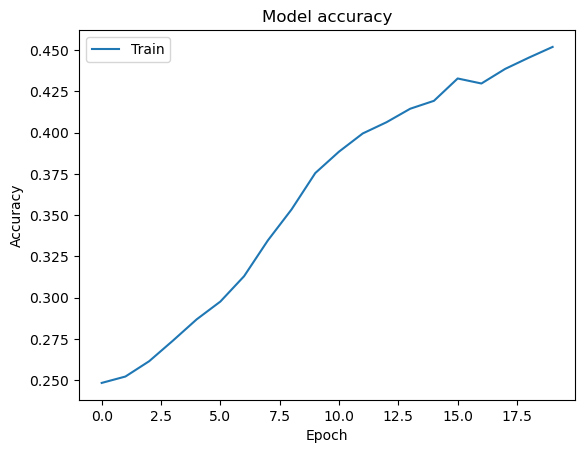

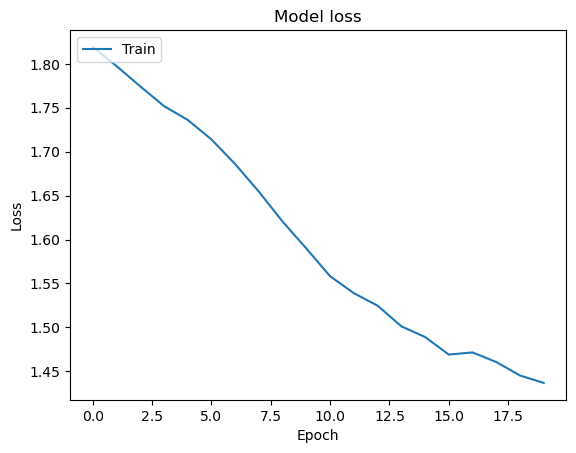

In [489]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [491]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.5121 - loss: 1.2764
Test accuracy: 0.4995


In [493]:
def predict_emotion(image):
    image = cv2.resize(image, (48, 48))
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    image = image / 255.0
    prediction = model.predict(image)
    print(prediction)
    return np.argmax(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[7.9416716e-01 4.6824655e-04 4.8278727e-02 2.3375485e-02 5.7335246e-02
  3.3309255e-02 4.3065891e-02]]


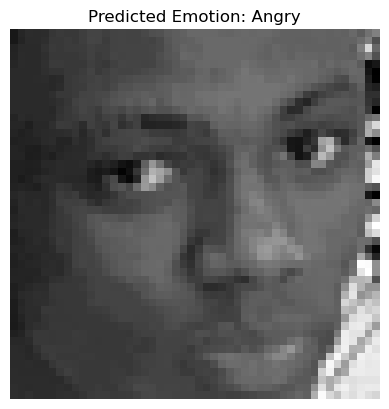

Predicted emotion: 0


In [535]:
sample_image = X_test[random.randint(0,1000)]
predicted_emotion = predict_emotion(sample_image)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
act_emotion = emotions[predicted_emotion]
plt.imshow(sample_image, cmap='gray')
plt.title(f"Predicted Emotion: {act_emotion}")
plt.axis('off')
plt.show()
print(f'Predicted emotion: {predicted_emotion}')